# Music-Classification-via-Convolutional-Neural-Networks
## Στειροπούλου Ευαγγελία
### 1115201800186

# FeedForward Neural Network

In [1]:
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install -U scikit-learn
!pip install torchmetrics

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 17.1 MB/s eta 0:00:00
Mounted at /content/gdrive


## Load mfccs Data

In [2]:
path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/mfccs'
test_data_path = path + '/data/music_genre_data_di/test/mfccs'
validation_data_path = path + '/data/music_genre_data_di/val/mfccs'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

# Μετατροπή των labels σε ακέραιους αριθμούς (0, 1, 2, 3)
classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

# Δημιουργία των Tensor αντικειμένων από τα numpy arrays
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

The runtime type, needs to be set at "GPU" mode.

## Build Neural Network

In [3]:
class FullyConnectedNeuralNetwork(nn.Module): ##NeuralNetwork iS A subclass of nn.module
    def __init__(self):
        super(FullyConnectedNeuralNetwork, self).__init__() ## call the constructor of super
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26 , 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    ## Every nn.Module subclass implements the operations on input data in the forward method.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cpu"
model = FullyConnectedNeuralNetwork().to(device)

## Set Neural Network training function

In [4]:
def train_network(model, optimizer, dataloader, loss_function, num_epochs):
    size = len(dataloader.dataset)

    for epoch in range(num_epochs):
        loss = 0.0
        print("Epoch: ", epoch+1)
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = loss_function(outputs, targets)

            # Clear the gradients and compute new gradients (backward pass)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() # Update the weights

            if batch_idx % 64 == 0:
                loss, current = loss.item(), batch_idx * len(data)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    print('Training finished.')
    return model

## Set evaluation function

In [5]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, dataloader, loss_function):
    model.eval()  # Put the model in evaluation mode
    device = next(model.parameters()).device

    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())


    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

## Train Neural Network

In [6]:
import torch.optim as optim
import time

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# To compare later the CPU with the GPU time
startTime = time.time()

# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro_cpu, accuracy_cpu, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

# Saving the CPU time
endTime = time.time()
CPUtime = endTime - startTime

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro_cpu}")
print(f"Accuracy: {accuracy_cpu*100} %")
print("Confusion Matrix:")
print(confusion_mat)
print("Device is ", device)

# Return the trained model
trained_model = model

Epoch:  1
loss: 1.422900  [    0/ 3200]
loss: 1.395402  [ 1024/ 3200]
loss: 1.385391  [ 2048/ 3200]
loss: 1.364070  [ 3072/ 3200]
Epoch:  2
loss: 1.391671  [    0/ 3200]
loss: 1.383563  [ 1024/ 3200]
loss: 1.364125  [ 2048/ 3200]
loss: 1.395983  [ 3072/ 3200]
Epoch:  3
loss: 1.386002  [    0/ 3200]
loss: 1.385000  [ 1024/ 3200]
loss: 1.380992  [ 2048/ 3200]
loss: 1.389248  [ 3072/ 3200]
Epoch:  4
loss: 1.379633  [    0/ 3200]
loss: 1.385167  [ 1024/ 3200]
loss: 1.364618  [ 2048/ 3200]
loss: 1.387938  [ 3072/ 3200]
Epoch:  5
loss: 1.365645  [    0/ 3200]
loss: 1.368865  [ 1024/ 3200]
loss: 1.350684  [ 2048/ 3200]
loss: 1.363681  [ 3072/ 3200]
Epoch:  6
loss: 1.375951  [    0/ 3200]
loss: 1.383690  [ 1024/ 3200]
loss: 1.352772  [ 2048/ 3200]
loss: 1.379643  [ 3072/ 3200]
Epoch:  7
loss: 1.361395  [    0/ 3200]
loss: 1.371944  [ 1024/ 3200]
loss: 1.341046  [ 2048/ 3200]
loss: 1.371602  [ 3072/ 3200]
Epoch:  8
loss: 1.364389  [    0/ 3200]
loss: 1.343282  [ 1024/ 3200]
loss: 1.350962  [ 20

We notice that the accuracy of the predictions, is about 62% and the F1 score is about 0.61. These results occur after 30 epochs.

## Train Network with GPU

In [7]:
import torch.optim as optim

# if we want to utilize the GPU (if available), we need to assign the model to the correct device
if torch.cuda.is_available():
    device="cuda"
    print("GPU available")
else:
    device="cpu"

print ("device=",device)
model = FullyConnectedNeuralNetwork().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Saving the CPU time
startTime = time.time()
# Train the model
train_network(model, optimizer, train_dataloader, loss_function, num_epochs)

# Evaluate the trained model
avg_loss, f1_score_macro_gpu, accuracy_gpu, confusion_mat = evaluate_model(model, test_dataloader, loss_function)

endTime = time.time()
GPUtime = endTime - startTime

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"F1 Score (Macro): {f1_score_macro_gpu}")
print(f"Accuracy: {accuracy_gpu*100} %")
print("Confusion Matrix:")
print(confusion_mat)

# Return the trained model
trained_model = model

GPU available
device= cuda
Epoch:  1
loss: 1.395350  [    0/ 3200]
loss: 1.378733  [ 1024/ 3200]
loss: 1.395556  [ 2048/ 3200]
loss: 1.380105  [ 3072/ 3200]
Epoch:  2
loss: 1.373194  [    0/ 3200]
loss: 1.382900  [ 1024/ 3200]
loss: 1.369512  [ 2048/ 3200]
loss: 1.404118  [ 3072/ 3200]
Epoch:  3
loss: 1.383798  [    0/ 3200]
loss: 1.367095  [ 1024/ 3200]
loss: 1.369350  [ 2048/ 3200]
loss: 1.387893  [ 3072/ 3200]
Epoch:  4
loss: 1.374493  [    0/ 3200]
loss: 1.344042  [ 1024/ 3200]
loss: 1.380484  [ 2048/ 3200]
loss: 1.363892  [ 3072/ 3200]
Epoch:  5
loss: 1.362197  [    0/ 3200]
loss: 1.374937  [ 1024/ 3200]
loss: 1.378062  [ 2048/ 3200]
loss: 1.358226  [ 3072/ 3200]
Epoch:  6
loss: 1.351377  [    0/ 3200]
loss: 1.370353  [ 1024/ 3200]
loss: 1.378505  [ 2048/ 3200]
loss: 1.367468  [ 3072/ 3200]
Epoch:  7
loss: 1.347587  [    0/ 3200]
loss: 1.372993  [ 1024/ 3200]
loss: 1.374020  [ 2048/ 3200]
loss: 1.338304  [ 3072/ 3200]
Epoch:  8
loss: 1.335882  [    0/ 3200]
loss: 1.331495  [ 1024/

Lets compare the running time of the CPU and GPU training of the network.

In [8]:
# Compare the times
print("CPU time: ", CPUtime, "seconds.")
print("GPU time: ", GPUtime, "seconds.")

#Compare accuracy and f1 score of CPU - GPU
print("\nCPU accuracy: ", accuracy_cpu)
print("GPU accuracy: " , accuracy_gpu)
print("\nCPU F1-score: ", f1_score_macro_cpu)
print("GPU F1-score: ", f1_score_macro_gpu)

CPU time:  9.046438694000244 seconds.
GPU time:  13.15014362335205 seconds.

CPU accuracy:  0.6213662790697675
GPU accuracy:  0.563953488372093

CPU F1-score:  0.6109462089655253
GPU F1-score:  0.553877196275374


As we can notice, the GPU execution, is slower than CPU. The results are slightly worse than with CPU, since the accuracy is 56%, and f1-score is 0.55.

## Best snapshot of the model

In [9]:
def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function)

        print(f"Epoch: {epoch+1}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation F1: {val_f1:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_model = model
            best_f1 = val_f1
            best_epoch = epoch+1


    print("\nBest f1 score achieved after ", best_epoch, " epochs.")

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function)

    print("\nBest Model Performance on Test Set:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    return best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [10]:
best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs
)

Epoch:  1
loss: 1.091373  [    0/ 3200]
loss: 0.910114  [ 1024/ 3200]
loss: 0.752775  [ 2048/ 3200]
loss: 1.116487  [ 3072/ 3200]
Training finished.
Epoch: 1
Validation Loss: 0.9823
Validation F1: 0.6177
Validation Accuracy: 0.6475
Epoch:  1
loss: 1.126132  [    0/ 3200]
loss: 1.022021  [ 1024/ 3200]
loss: 1.011147  [ 2048/ 3200]
loss: 0.983160  [ 3072/ 3200]
Training finished.
Epoch: 2
Validation Loss: 0.9810
Validation F1: 0.6253
Validation Accuracy: 0.6425
Epoch:  1
loss: 1.012640  [    0/ 3200]
loss: 1.000911  [ 1024/ 3200]
loss: 1.075384  [ 2048/ 3200]
loss: 1.186344  [ 3072/ 3200]
Training finished.
Epoch: 3
Validation Loss: 0.9744
Validation F1: 0.6160
Validation Accuracy: 0.6288
Epoch:  1
loss: 1.127166  [    0/ 3200]
loss: 1.191701  [ 1024/ 3200]
loss: 1.200167  [ 2048/ 3200]
loss: 0.788102  [ 3072/ 3200]
Training finished.
Epoch: 4
Validation Loss: 0.9781
Validation F1: 0.5871
Validation Accuracy: 0.5925
Epoch:  1
loss: 0.876016  [    0/ 3200]
loss: 1.166279  [ 1024/ 3200]
lo

We are comparing the results that were generated with GPU, since the device I decided to use afterwards is GPU.
The accuracy is now 60%, and the f1-score is around 0.58.The results are better than before. Also these results were achieved after 26 epochs. This shows that the model stops learning after that.

# Convolutional Neural Network

## Load spectrograms data

In [11]:
# path = os.getcwd()
# print(path)

path = '/content/gdrive/My Drive/Project3'

#create the paths for the data
training_data_path = path + '/data/music_genre_data_di/train/melgrams'
test_data_path = path + '/data/music_genre_data_di/test/melgrams'
validation_data_path = path + '/data/music_genre_data_di/val/melgrams'

X_train = np.load(training_data_path + '/X.npy')
y_train = np.load(training_data_path + '/labels.npy')
X_val   = np.load(validation_data_path + '/X.npy')
y_val   = np.load(validation_data_path + '/labels.npy')
X_test  = np.load(test_data_path + '/X.npy')
y_test  = np.load(test_data_path + '/labels.npy')

classes = np.unique(y_train)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

y_train = np.array([class_to_idx[label] for label in y_train])
y_val = np.array([class_to_idx[label] for label in y_val])
y_test = np.array([class_to_idx[label] for label in y_test])

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


Bellow I will plot a random melgram of each class. I will retrieve the class names from the labels in the dataset.

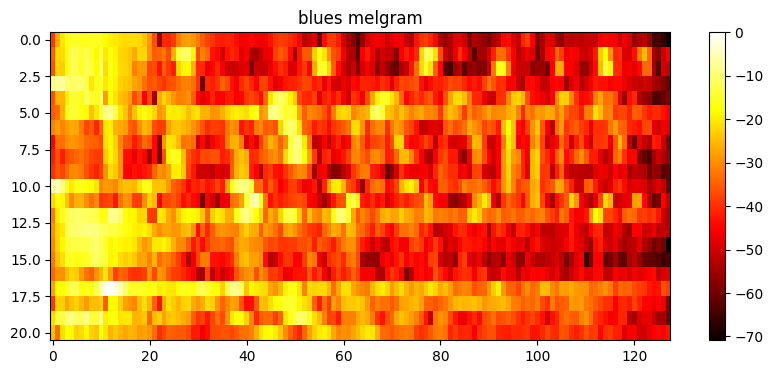

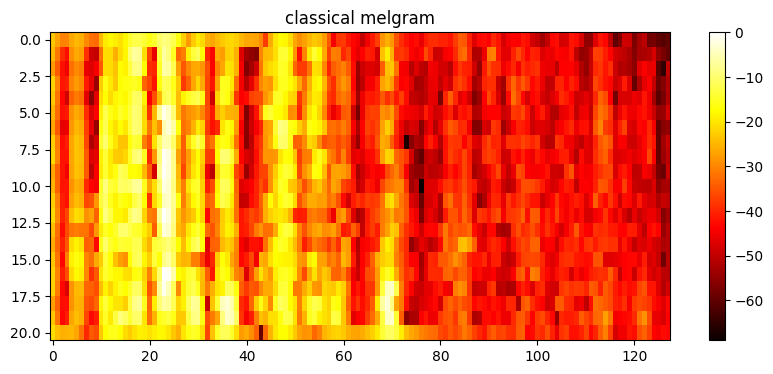

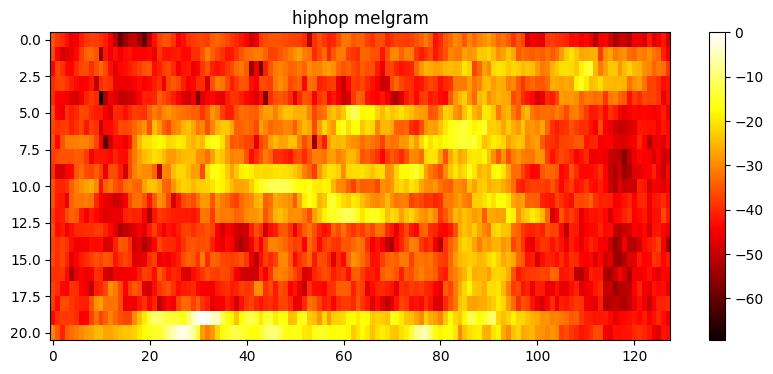

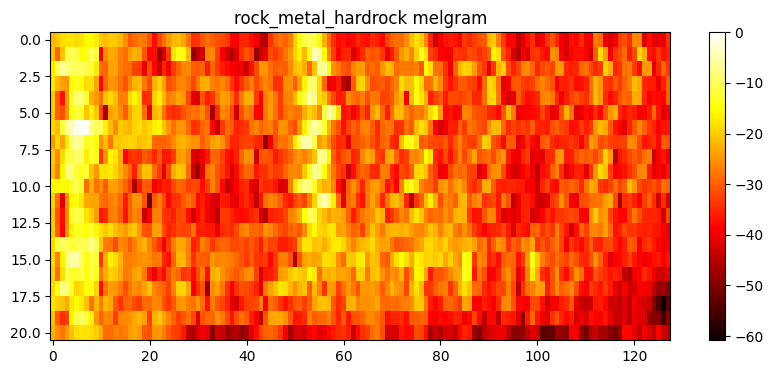

In [12]:
import random

def visualize_melgram(melgram, class_name):
    plt.figure(figsize=(10, 4))
    plt.imshow(melgram, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(class_name + ' melgram')
    plt.show()

# Function to plot a random melgram from each class
def plot_random_melgram_from_each_class(dataset, class_labels, class_names):
    classes = np.unique(class_labels)
    for class_label in classes:
        indices = np.where(class_labels == class_label)[0]
        # Select a random index
        random_index = random.choice(indices)
        melgram, label = dataset[random_index]
        class_name = class_names[class_label]  # Get the class name corresponding to the class label
        visualize_melgram(melgram, class_name)

# Retrieve the class names from the class_to_idx dictionary
class_names = [class_label for class_label, class_index in class_to_idx.items()]

# Plot a random melgram from each class in the training dataset
plot_random_melgram_from_each_class(train_dataset, y_train, class_names)


## Build Neural Network

The neural network architecture is 4 convolutional layers and a fully connected stack of 5 layers. The convolutional layers have a kernel size of 5 and the input channels are 1, 16, 32, 64, and 128.

In [13]:
#set a convolutional neural network with 5 kernels and 4 convolutional layers with sequential 1,16,32,64,128
#and the exit of the last layer to be inserted in a fully connected layer with 5 layers and neurons x(dimensions of the exit of the last convolutional layer), 1024,256,32, out_dim
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)

        self.flatten = nn.Flatten()

        # Fully connected stack 5*12*128 = 71680
        self.connected_stack = nn.Sequential(
            nn.Linear(71680, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.connected_stack(x)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet().to(device)

## Train Network

We provide the functions we used before, after a few changes that are necessary for this problem.

In [14]:
from torchmetrics import F1Score, Accuracy

def train_network(model, optimizer, dataloader, loss_function, num_epochs, device):
    model.train()  # Put the model in training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(dataloader):
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            optimizer.zero_grad()  # Clear the gradients

            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()  # Update the weights

            running_loss += loss.item()

            if batch_idx % 64 == 99:  # Print the loss every 64 batches
                print(f"Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0

def evaluate_model(model, dataloader, loss_function, device):
    model.eval()  # Put the model in evaluation mode

    device = next(model.parameters()).device
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            data = data.unsqueeze(1)  # Add a channel dimension
            targets = targets.to(device)

            predictions = model(data)
            loss = loss_function(predictions, targets)
            total_loss += loss.item()

            all_predictions.extend(predictions.argmax(1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)

    # Calculate F1 score, accuracy, and confusion matrix
    f1_score_macro = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    confusion_mat = confusion_matrix(all_targets, all_predictions)

    return avg_loss, f1_score_macro, accuracy, confusion_mat

In [15]:
import copy

def train_and_evaluate(model, optimizer, train_dataloader, val_dataloader, test_dataloader, loss_function, num_epochs):
    best_model = None
    best_f1 = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        # Train the model
        train_network(model, optimizer, train_dataloader, loss_function, 1, device)

        # Evaluate the model on the validation set
        val_loss, val_f1, val_accuracy, val_confusion_mat = evaluate_model(model, val_dataloader, loss_function, device)

        print(f"Epoch: {epoch+1}")
        print("Validation Loss: ", val_loss)
        print("Validation F1: ", val_f1)
        print("Validation Accuracy: ", val_accuracy* 100 , "%")

        # Save the model with the best F1 score on the validation set
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch + 1
            best_model = copy.deepcopy(model)

    # Evaluate the best model on the test set
    test_loss, test_f1, test_accuracy, test_confusion_mat = evaluate_model(best_model, test_dataloader, loss_function, device)

    print("Best Model Performance on Test Set:")
    print("Test Loss: ", test_loss)
    print("Test F1: ", test_f1)
    print("Test Accuracy: ", test_accuracy* 100 , "%")
    print("Test Confusion Matrix:")
    print(test_confusion_mat)

    print("\nBest F1 macro average score: " ,test_f1 ," achieved after ", best_epoch, " epochs.")

    return best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat

In [16]:
# Hyperparameters and Network initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet().to(device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 10

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)
print("\nBest F1 macro average score achieved after ", best_epoch, " epochs.")

Epoch:  1
Epoch: 1
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  2
Epoch: 2
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  3
Epoch: 3
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  4
Epoch: 4
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  5
Epoch: 5
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  6
Epoch: 6
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  7
Epoch: 7
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  8
Epoch: 8
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  9
Epoch: 9
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Epoch:  10
Epoch: 10
Validation Loss:  nan
Validation F1:  0.1
Validation Accuracy:  25.0 %
Best Model Performance on Test Set:
Test Loss:  nan
Test F1:  0.09529411764705882
Test Accuracy:  

From the results it is clear that the model is unable to train. The loss immediately goes to infinity so it means that the principal features cannot be extracted. I choose to test the results for 10 epochs, to save time, since we we can see from the beginning that the network model is unable to train. The fact that the training is not possible, highlights the need to modify our model, so we will recreate it with padding.

## Set padding to the Convolutional Network

We will set Max Pooling layers of kernel size 2 and padding 2.

In [17]:
#set convolutional network with padding to 2 and kernel size to 2
import torch.nn.functional as F

class ConvolutionalNet2(nn.Module):
    def __init__(self):
        super(ConvolutionalNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        self.flatten = nn.Flatten()
        self.connected_stack = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.Linear(1024, 256),
            nn.Linear(256, 32),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv4(x)), kernel_size=2)
        x = self.flatten(x)

        logits = self.connected_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)

In [18]:
# Hyperparameters and Network initialisation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvolutionalNet2().to(device)
print("device: ", device)

# Define the optimizer, learning rate, and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002)
loss_function = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 30

# Train the model and find optimal model
best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
    model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)


device:  cuda:0
Epoch:  1
Epoch: 1
Validation Loss:  1.3222085165977477
Validation F1:  0.28728082782408737
Validation Accuracy:  42.125 %
Epoch:  2
Epoch: 2
Validation Loss:  1.2439386940002441
Validation F1:  0.32297586776152176
Validation Accuracy:  39.25 %
Epoch:  3
Epoch: 3
Validation Loss:  1.2287509167194366
Validation F1:  0.2920725259201782
Validation Accuracy:  36.625 %
Epoch:  4
Epoch: 4
Validation Loss:  1.0831747591495513
Validation F1:  0.43679652138724856
Validation Accuracy:  48.0 %
Epoch:  5
Epoch: 5
Validation Loss:  1.0769120800495147
Validation F1:  0.4078846036242883
Validation Accuracy:  45.75 %
Epoch:  6
Epoch: 6
Validation Loss:  0.9915229797363281
Validation F1:  0.5731671978642783
Validation Accuracy:  56.99999999999999 %
Epoch:  7
Epoch: 7
Validation Loss:  0.9441415786743164
Validation F1:  0.5582996646843772
Validation Accuracy:  58.375 %
Epoch:  8
Epoch: 8
Validation Loss:  0.9081870758533478
Validation F1:  0.5748072793264382
Validation Accuracy:  59.6249

The best snapshot of the model is found after 24 epochs, with f1-score about 0.67.

## Optimization Algorithms

First I will define a function that prints the results of the algorithms in a table form, using the Dataframe format from "pandas" module.

In [19]:
import pandas as pd

def print_results_table(results):
    # Create a DataFrame from the results dictionary
    df_results = pd.DataFrame(results).T

    # Rename the columns
    df_results.columns = ['Accuracy', 'F1']

    # Add the algorithm names as a new column
    df_results['Algorithm'] = df_results.index

    # Set the 'Algorithm' column as the index
    df_results.set_index('Algorithm', inplace=True)

    return df_results

Next, I will define a function that selects the best results from the dataframe and prints them.

In [20]:
def best_results(df_results):
    # Find the optimizer with the best accuracy
    best_accuracy_optimizer = df_results['Accuracy'].idxmax()
    best_accuracy = df_results.loc[best_accuracy_optimizer, 'Accuracy']

    # Find the optimizer with the best F1 score
    best_f1_optimizer = df_results['F1'].idxmax()
    best_f1 = df_results.loc[best_f1_optimizer, 'F1']

    # Create a DataFrame for the best results
    best_results_df = pd.DataFrame({
        'Optimizer': [best_accuracy_optimizer, best_f1_optimizer],
        'Accuracy': [best_accuracy, best_f1]
    }, index=['Best Accuracy', 'Best F1 Score'])

    return best_results_df

I will test the Neural Network for the pytorch optimizers bellow, using 30 epochs, learning rate 0.002 and as loss function, the CrossEntropyLoss. I will test several algorithms provided by pytoch, and I will compare the results.

In [21]:
#run all  the optimization algorithms of pytorch and compare the results
import torch.optim as optim

algorithms = {
    'Adadelta': optim.Adadelta,
    'Adagrad': optim.Adagrad,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'Adamax': optim.Adamax,
    'ASGD': optim.ASGD,
    'NAdam': optim.NAdam,
    'RAdam': optim.RAdam,
    'RMSprop': optim.RMSprop,
    'Rprop': optim.Rprop,
    'SGD': optim.SGD
}

loss_function = nn.CrossEntropyLoss()
num_epochs = 30

# Create an empty dictionary to store the results
results = {}

# Hyperparameters and Network initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

for algorithm_name, algorithm_class in algorithms.items():
    print(algorithm_name)
    model = ConvolutionalNet2().to(device)

    # Define the optimizer, learning rate, and loss function
    optimizer = algorithm_class(model.parameters(), lr=0.002)
    print("Optimizer: ", algorithm_name)

    # Train the model and find optimal model
    best_epoch, best_model, test_loss, test_f1, test_accuracy, test_confusion_mat = train_and_evaluate(
        model, optimizer, train_dataloader, validation_dataloader, test_dataloader, loss_function, num_epochs)

    # Store the results in the dictionary
    results[algorithm_name] = {'accuracy': test_accuracy, 'f1': test_f1}

device:  cuda
Adadelta
Optimizer:  Adadelta
Epoch:  1
Epoch: 1
Validation Loss:  1.3807708072662352
Validation F1:  0.16762223283962419
Validation Accuracy:  28.749999999999996 %
Epoch:  2
Epoch: 2
Validation Loss:  1.362048306465149
Validation F1:  0.24722222222222223
Validation Accuracy:  35.125 %
Epoch:  3
Epoch: 3
Validation Loss:  1.3342161560058594
Validation F1:  0.2633406593406593
Validation Accuracy:  36.875 %
Epoch:  4
Epoch: 4
Validation Loss:  1.2905083966255189
Validation F1:  0.29437499999999994
Validation Accuracy:  41.375 %
Epoch:  5
Epoch: 5
Validation Loss:  1.246026644706726
Validation F1:  0.2923487869081847
Validation Accuracy:  38.75 %
Epoch:  6
Epoch: 6
Validation Loss:  1.1990292954444886
Validation F1:  0.3937808993993966
Validation Accuracy:  45.25 %
Epoch:  7
Epoch: 7
Validation Loss:  1.1527417969703675
Validation F1:  0.3996704115734656
Validation Accuracy:  46.5 %
Epoch:  8
Epoch: 8
Validation Loss:  1.1267888498306275
Validation F1:  0.4020319926494694
Va

In [22]:
df_results = print_results_table(results)
# Print the results in a table format
pd.DataFrame(df_results).T

Algorithm,Adadelta,Adagrad,Adam,AdamW,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD
Accuracy,0.646076,0.757994,0.646802,0.692587,0.716570,0.696221,0.235465,0.694767,0.646802,0.653343,0.678779
F1,0.646242,0.756246,0.656903,0.698515,0.724806,0.706873,0.095294,0.699481,0.647611,0.657362,0.685902


Now lets get the best result from the table above.

In [23]:
best_results(df_results)

,Optimizer,Accuracy
Best Accuracy,Adagrad,0.757994
Best F1 Score,Adagrad,0.756246


As we can see $Adagrad$ and $Adamax$ have the best accuracy and the best f1 score as well, as I noticed after several test runs. For this specific runtime, $Adagrad$ has the best scores on both accuracy and f1-score.